# Imperfect tests

This model includes the sensitivity and specificity of the diagnostic test. 

\begin{equation}
  \begin{aligned}
    T_i &\sim \operatorname{Bernoulli}(p_i) \\
    p_i &= \gamma_s\theta_i + (1-\gamma_e)(1 - \theta_i),  \\
    g(\theta_i) &= g(\theta) + \boldsymbol{x}_i^T\beta,  \\
    \beta &\sim \operatorname{Normal}(\mu, \Sigma), \\ 
    \theta &\sim \operatorname{Beta}(a^p, b^p) \\
    \gamma_s &\sim \operatorname{Beta}(a^s, b^s), \\
    \gamma_e &\sim \operatorname{Beta}(a^e, b^e), \\    
  \end{aligned}  
\end{equation}

where $a^p, a^s, a^e, b^p, b^s, b^e \in \mathbb{R}_{++}$ are fixed hyperparameters.
This model does not include prior knowledge about the correlation between specificity and sensitivity. 


In [27]:
import numpy as np
import pandas as pd
import pystan as ps
from scipy.special import logit, expit
import networkx as nx
from networkx.drawing.nx_pydot import graphviz_layout

import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az

import pickle
from tqdm.notebook import tqdm

import sys  
sys.path.insert(0, '../scripts/')

from artificial_data import GenerateData

## Notebook settings

In [5]:
sns.set()
plt.rc('mathtext', fontset="cm")
ro = np.random.RandomState(1000)
%matplotlib inline

In [4]:
#compiled = False
compiled = True

In [17]:
if compiled: 
    sm = pickle.load(open('pickles/imperfect_test.pkl', 'rb'))
else: 
    sm = ps.StanModel(file = 'stan_codes/imperfect_test.stan')
    with open('pickles/imperfect_test.pkl', 'wb') as f:
        pickle.dump(sm, f)

### Data

First we describe data created artificially. 

In [18]:
spec = 0.85
sens = 0.8

beta = np.array([0.1, 2.5, -1.0, 1.2, 0.3]).reshape(-1,1)
prevalence = 0.1

theta = expit(logit(prevalence) + x@beta)
p = sens*theta + (1 - spec)*(1 - theta)

T = ro.binomial(n = 1, p = p)

alpha_s = 4
beta_s  = 1
alpha_e = 4
beta_e  = 1

data = {
    "n_samples"    : n_samples,
    "n_predictors" : n_predictors,
    "T"            : T.flatten(),
    "x"            : x,
    
    "Sigma"        : Sigma,
    "mu"           : mu,
    "alpha_p"      : alpha_p,
    "beta_p"       : beta_p,
    "alpha_s"      : alpha_s,
    "beta_s"       : beta_s,
    "alpha_e"      : alpha_e,
    "beta_e"       : beta_e,
}

T.mean()

0.34

And we apply it

In [48]:
fit_imperfect = sm.sampling(data=data, iter=5000)
summary = az.summary(fit_imperfect)

First we observe the relation between $\theta_i$ and $p_i$ among the individuals. 

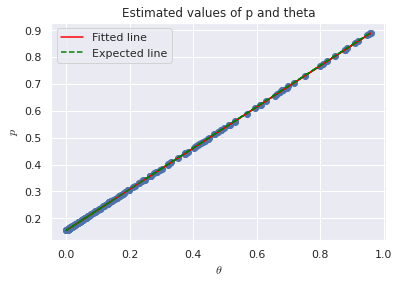

In [88]:
theta_values = summary[summary.index.str.contains('theta')]['mean']
p_values = summary[summary.index.str.contains('p\[')]['mean']

line_parameters = np.polyfit(theta_values, p_values, deg = 1)

spec_hat = summary.loc['spec', 'mean']
sens_hat = summary.loc['sens', 'mean']

plt.scatter(theta_values, p_values)
plt.plot(theta_values, theta_values * line_parameters[0] + line_parameters[1], 
         color = 'red', label = 'Fitted line')
plt.plot(theta_values, theta_values * (spec_hat + sens_hat - 1) + (1 - spec_hat), 
         color = 'green', label = 'Expected line', linestyle = '--')
plt.title('Estimated values of p and theta')
plt.xlabel(r'$\theta$')
plt.ylabel(r'$p$')
plt.legend()
plt.show()